# 📉 Customer Churn Prediction (EDA + Bagging on Best Model + CLI Input)
This notebook includes:
- ✅ Exploratory Data Analysis (EDA)
- ✅ Feature Engineering (Dates + Sentiment)
- ✅ Preprocessing (OneHotEncoding)
- ✅ SMOTE for imbalance
- ✅ SelectKBest feature selection
- ✅ Best model selection (F1-score)
- ✅ Bagging on the best model
- ✅ Command-line user input (`input()`) for prediction


## 1) Imports

In [2]:

import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

import joblib


## 2) Sentiment Analyzer Setup

In [3]:

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if pd.isna(text):
        return 0.0
    text = str(text)
    return float(sia.polarity_scores(text)["compound"])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 3) Load Dataset

In [5]:

df_raw = pd.read_csv("C:\\Users\\mathe\\Documents\\churn.csv").copy()
df_raw = df_raw.drop(columns=["sno"], errors="ignore")

print("Dataset Shape:", df_raw.shape)
df_raw.head()


Dataset Shape: (36992, 23)


,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,XW0DQ7H,Village,Platinum Membership,17-08-2017,No,xxxxxxxx,Gift Vouchers/Coupons,?,...,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,32,F,5K0N3X1,City,Premium Membership,28-08-2017,?,CID21329,Gift Vouchers/Coupons,Desktop,...,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,44,F,1F2TCL3,Town,No Membership,11-11-2016,Yes,CID12313,Gift Vouchers/Coupons,Desktop,...,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1
3,37,M,VJGJ33N,City,No Membership,29-10-2016,Yes,CID3793,Gift Vouchers/Coupons,Desktop,...,53.27,25239.56,6,567.66,No,Yes,Yes,Unsolved,Poor Website,1
4,31,F,SVZXCWB,City,No Membership,12-09-2017,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,...,113.13,24483.66,16,663.06,No,Yes,Yes,Solved,Poor Website,1


## 4) EDA (Exploratory Data Analysis)

In [6]:

print("Columns:")
print(df_raw.columns.tolist())

print("\nInfo:")
display(df_raw.info())

print("\nSummary Statistics (Numeric):")
display(df_raw.describe())

print("\nMissing Values (%):")
missing_pct = (df_raw.isna().sum() / len(df_raw) * 100).sort_values(ascending=False)
display(missing_pct[missing_pct > 0])


Columns:
['age', 'gender', 'security_no', 'region_category', 'membership_category', 'joining_date', 'joined_through_referral', 'referral_id', 'preferred_offer_types', 'medium_of_operation', 'internet_option', 'last_visit_time', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days', 'points_in_wallet', 'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback', 'churn_risk_score']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   security_no                   36992 non-null  object 
 3   region_category               31564 non-null  object 
 4   membership_category           36992 non-null  object 


None


Summary Statistics (Numeric):


,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,0.540982
std,15.867412,228.819900,398.289149,19444.806226,194.063624,0.498324
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,0.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,0.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,1.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,1.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,1.000000



Missing Values (%):


region_category          14.673443
points_in_wallet          9.307418
preferred_offer_types     0.778547
dtype: float64

### 4.1 Target Distribution

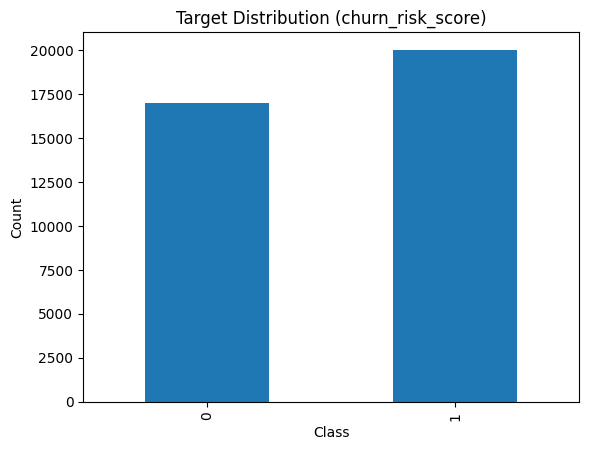

churn_risk_score
1    20012
0    16980
Name: count, dtype: int64


In [7]:

target_col = "churn_risk_score"

plt.figure()
df_raw[target_col].value_counts().sort_index().plot(kind="bar")
plt.title("Target Distribution (churn_risk_score)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

print(df_raw[target_col].value_counts())


### 4.2 Categorical Feature Distributions (Top Categories)

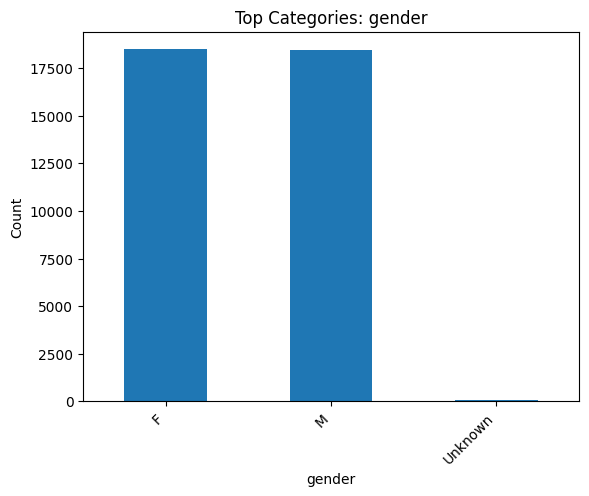

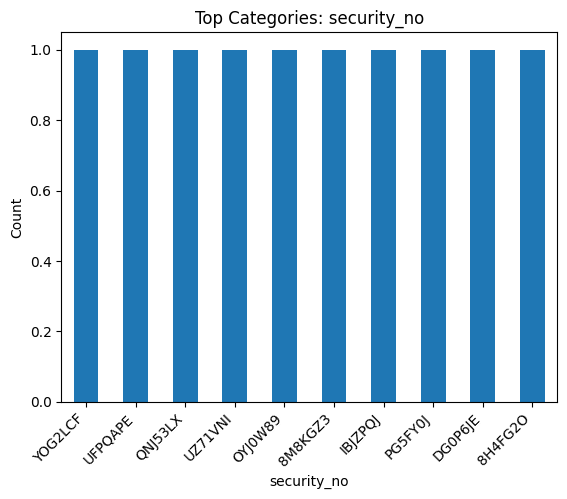

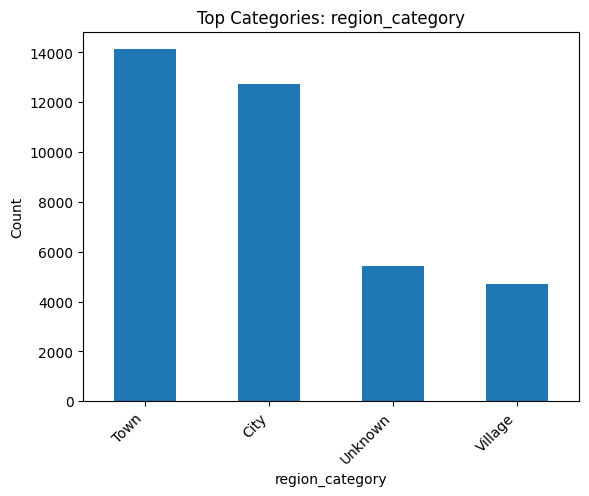

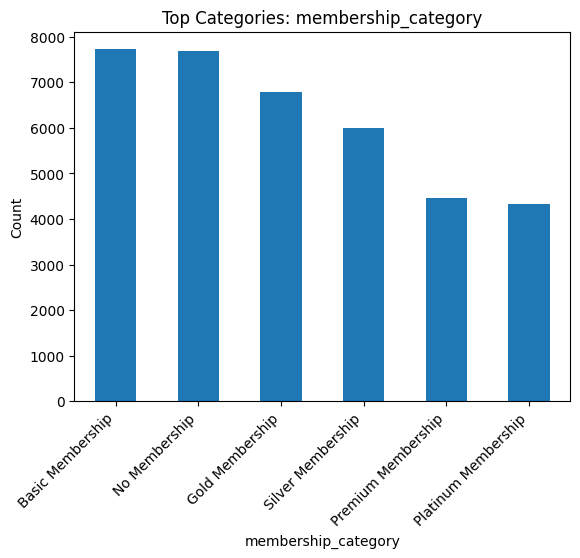

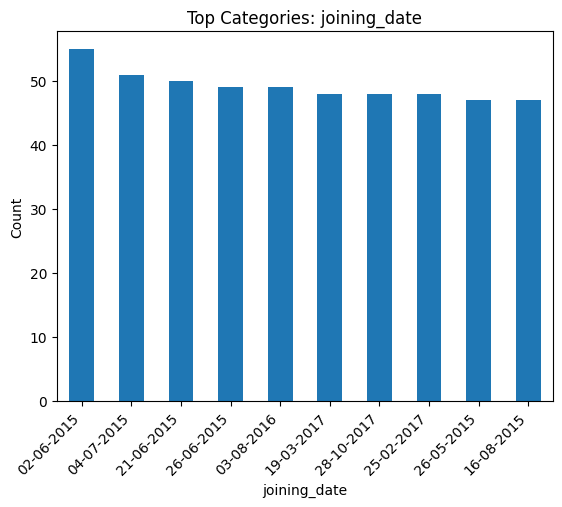

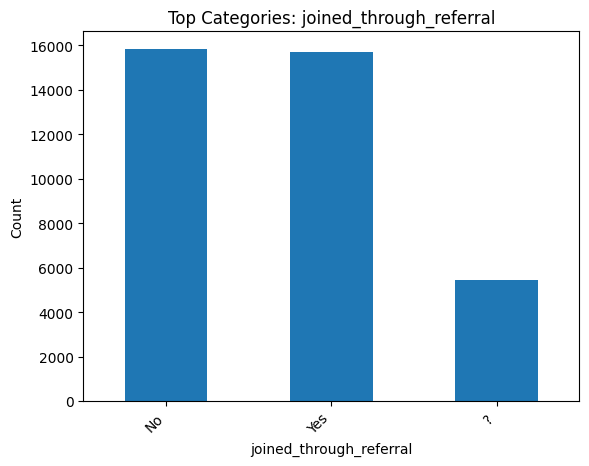

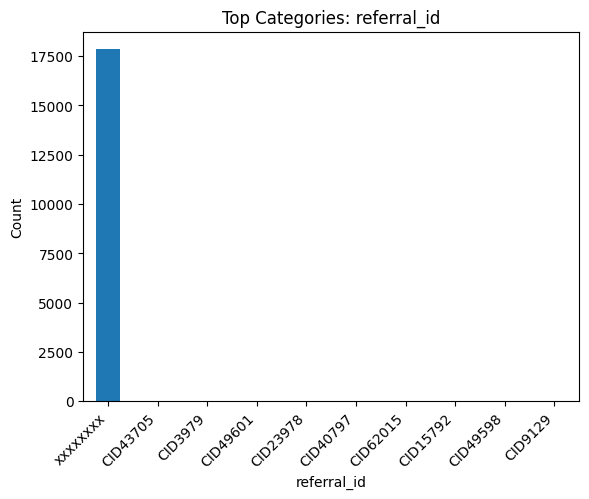

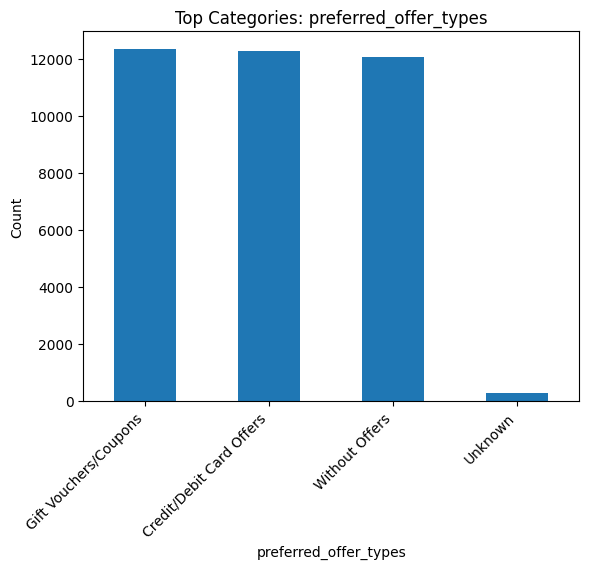

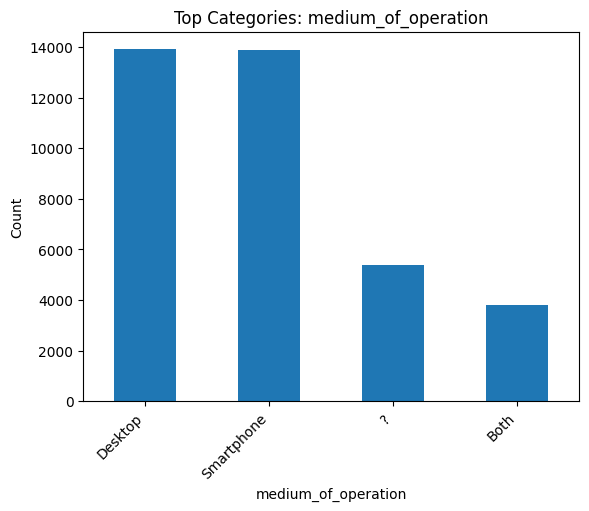

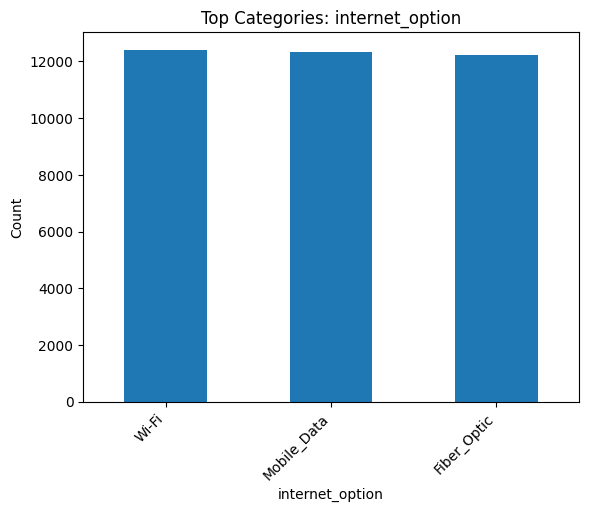

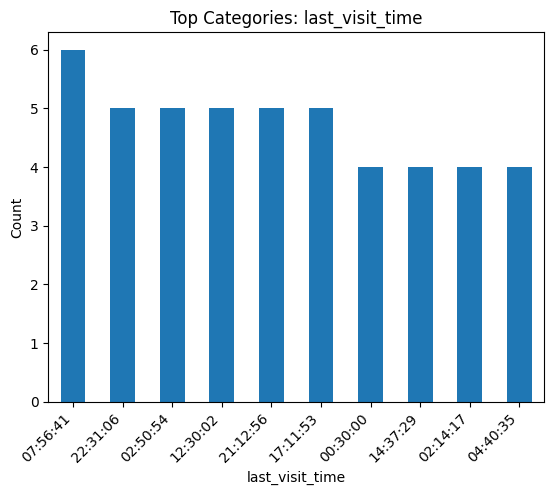

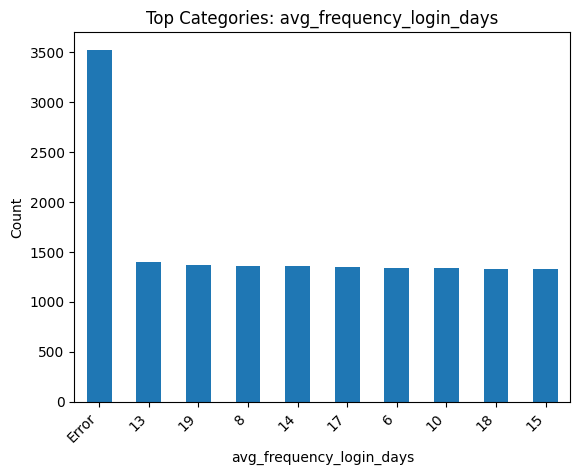

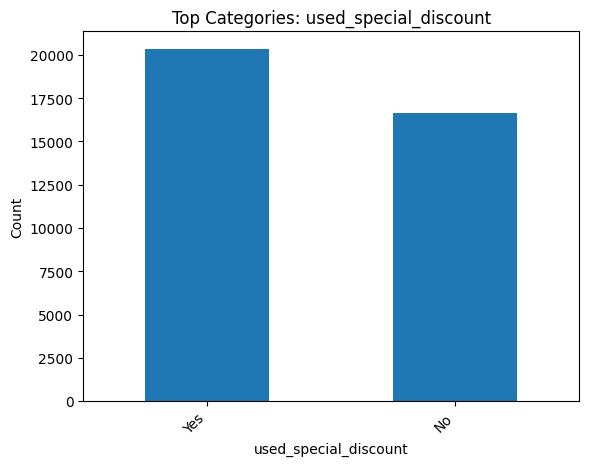

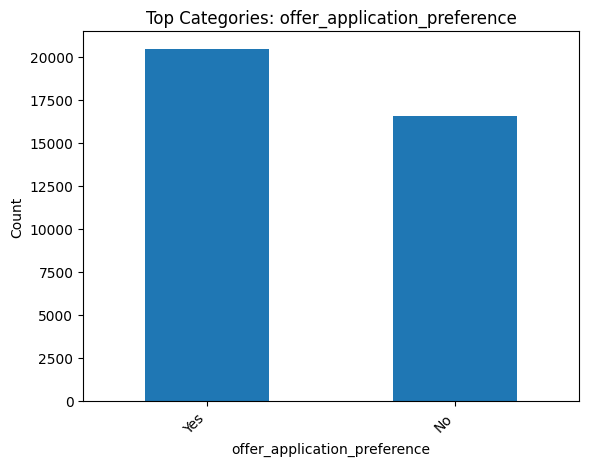

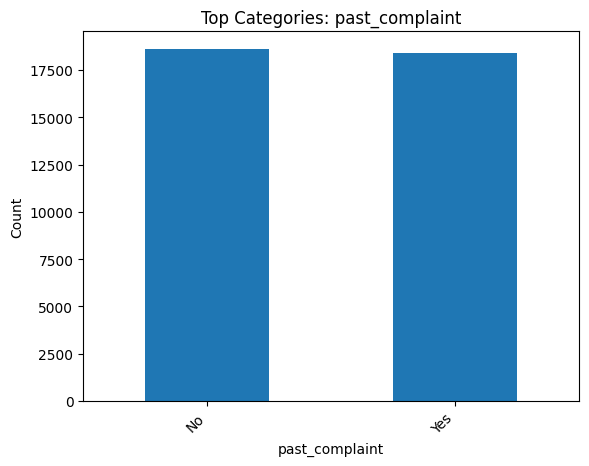

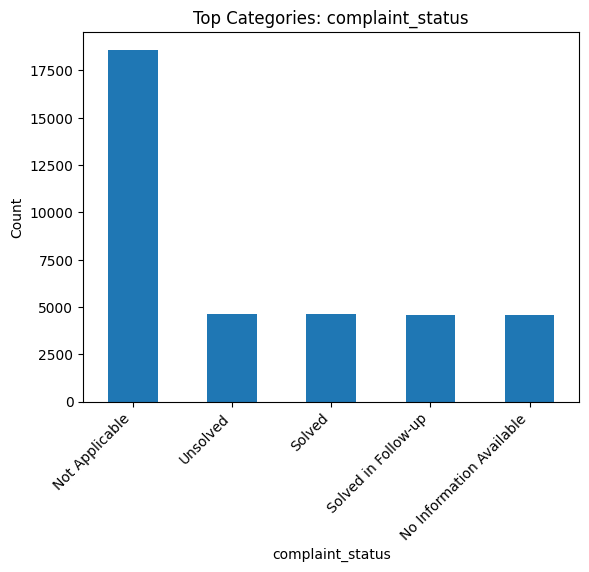

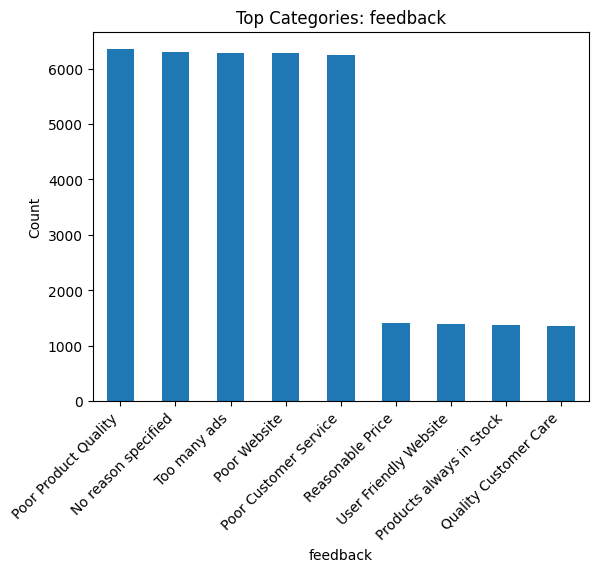

In [8]:

categorical_cols_eda = df_raw.select_dtypes(include=["object", "bool"]).columns.tolist()
categorical_cols_eda = [c for c in categorical_cols_eda if c != target_col]

for col in categorical_cols_eda:
    plt.figure()
    df_raw[col].fillna("Unknown").astype(str).value_counts().head(10).plot(kind="bar")
    plt.title(f"Top Categories: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.show()


### 4.3 Numeric Feature Distributions

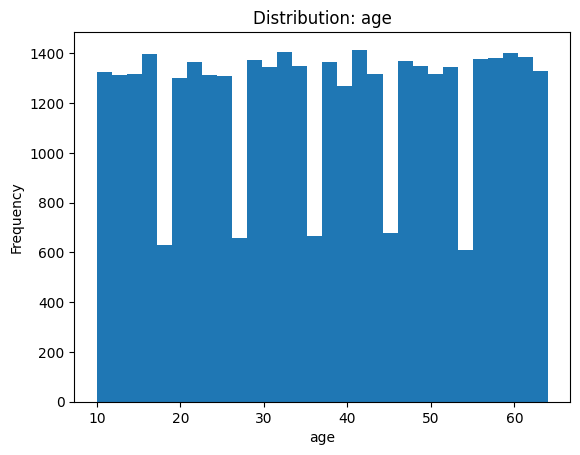

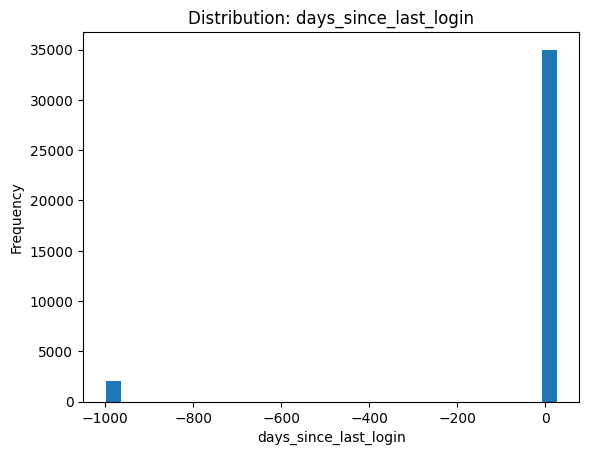

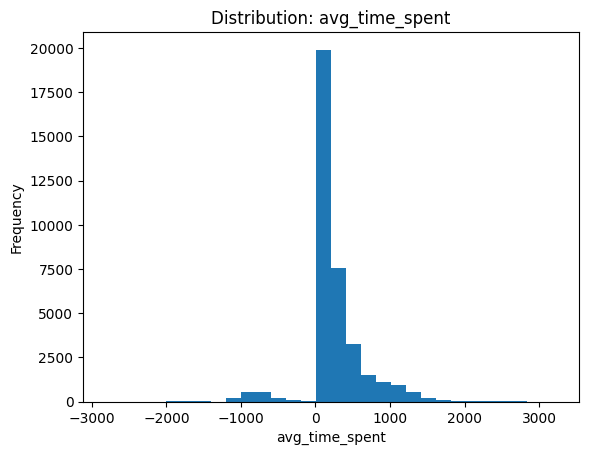

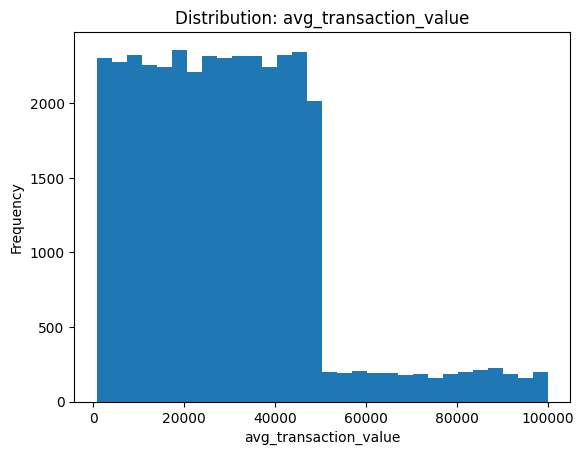

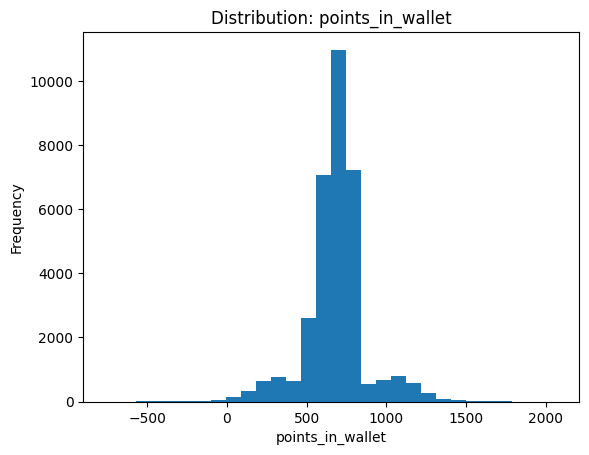

In [9]:

numeric_cols_eda = df_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()

for col in numeric_cols_eda:
    if col == target_col:
        continue
    plt.figure()
    df_raw[col].dropna().plot(kind="hist", bins=30)
    plt.title(f"Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


### 4.4 Correlation Heatmap (Numeric Features)

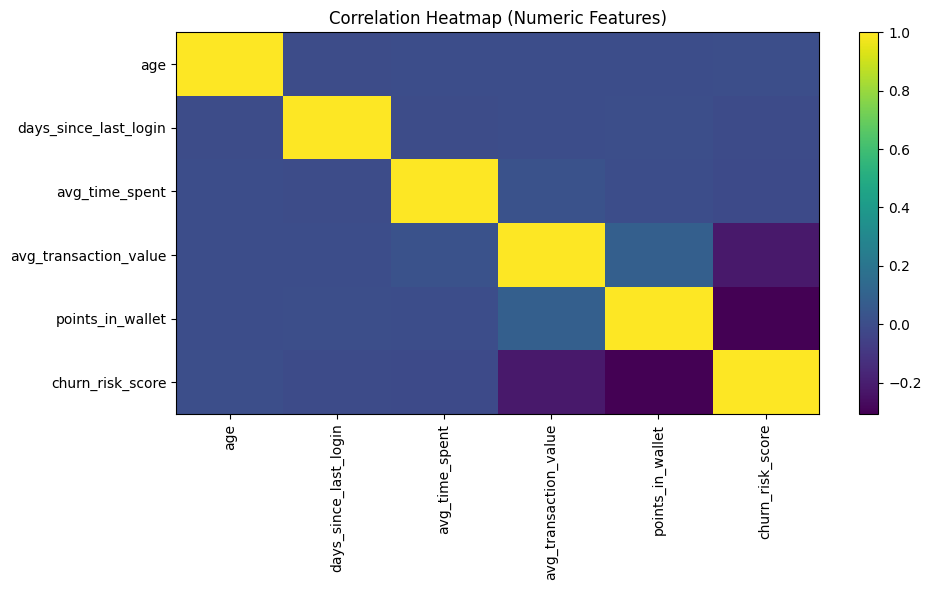

In [10]:

num_df = df_raw.select_dtypes(include=["int64", "float64"]).copy()
corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(10,6))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Correlation Heatmap (Numeric Features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()


## 5) Feature Engineering (Dates + Sentiment)

In [11]:

df = df_raw.copy()

df["joining_date"] = pd.to_datetime(df["joining_date"], errors="coerce")
df["last_visit_time"] = pd.to_datetime(df["last_visit_time"], errors="coerce")

today = pd.Timestamp(datetime.today().date())

df["days_since_joining"] = (today - df["joining_date"]).dt.days
df["days_since_last_visit"] = (today - df["last_visit_time"]).dt.days

df["days_since_joining"] = df["days_since_joining"].fillna(df["days_since_joining"].median())
df["days_since_last_visit"] = df["days_since_last_visit"].fillna(df["days_since_last_visit"].median())

df["sentiment_score"] = df["feedback"].apply(analyze_sentiment)

df = df.drop(columns=["joining_date", "last_visit_time", "feedback"], errors="ignore")
df.head()


C:\Users\mathe\AppData\Local\Temp\ipykernel_24996\1296556871.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["joining_date"] = pd.to_datetime(df["joining_date"], errors="coerce")
C:\Users\mathe\AppData\Local\Temp\ipykernel_24996\1296556871.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["last_visit_time"] = pd.to_datetime(df["last_visit_time"], errors="coerce")


,age,gender,security_no,region_category,membership_category,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,...,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,churn_risk_score,days_since_joining,days_since_last_visit,sentiment_score
0,18,F,XW0DQ7H,Village,Platinum Membership,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,...,17,781.75,Yes,Yes,No,Not Applicable,0,3078,-1,0.0000
1,32,F,5K0N3X1,City,Premium Membership,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,...,10,NaN,Yes,No,Yes,Solved,0,3067,-1,0.4939
2,44,F,1F2TCL3,Town,No Membership,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,...,22,500.69,No,Yes,Yes,Solved in Follow-up,1,3357,-1,-0.4767
3,37,M,VJGJ33N,City,No Membership,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,...,6,567.66,No,Yes,Yes,Unsolved,1,3370,-1,-0.4767
4,31,F,SVZXCWB,City,No Membership,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,...,16,663.06,No,Yes,Yes,Solved,1,3052,-1,-0.4767


## 6) Prepare X/y + Missing Values Handling

In [12]:

df = df.dropna(subset=[target_col])

y = df[target_col].astype(int)
X = df.drop(columns=[target_col])

X = X.drop(columns=["security_no", "referral_id"], errors="ignore")

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

for col in numeric_cols:
    X[col] = pd.to_numeric(X[col], errors="coerce")
    X[col] = X[col].fillna(X[col].median())

for col in categorical_cols:
    X[col] = X[col].fillna("Unknown").astype(str)

print("Numeric cols:", len(numeric_cols))
print("Categorical cols:", len(categorical_cols))


Numeric cols: 8
Categorical cols: 12


## 7) Train-Test Split

In [13]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "| Test:", X_test.shape)


Train: (29593, 20) | Test: (7399, 20)


## 8) Preprocessor + Pipeline Builder

In [14]:

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

def build_model_pipeline(model):
    pipe = ImbPipeline(steps=[
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("select", SelectKBest(score_func=f_classif, k=25)),
        ("model", model)
    ])
    return pipe


## 9) Train Candidate Models → Select Best by F1-score

C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



MODEL: Logistic Regression
Accuracy: 0.8757940262197594
F1 Score: 0.8801043705153294
Confusion Matrix:
 [[3107  289]
 [ 630 3373]]

MODEL: Decision Tree
Accuracy: 0.9156642789566157
F1 Score: 0.9217849084983705
Confusion Matrix:
 [[3098  298]
 [ 326 3677]]

MODEL: Random Forest
Accuracy: 0.9348560616299499
F1 Score: 0.940213346564128
Confusion Matrix:
 [[3127  269]
 [ 213 3790]]

MODEL: XGBoost
Accuracy: 0.9360724422219219
F1 Score: 0.9412932853419387
Confusion Matrix:
 [[3134  262]
 [ 211 3792]]
[LightGBM] [Info] Number of positive: 16009, number of negative: 16009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 32018, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

C:\Users\mathe\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,Accuracy,F1 Score
3,XGBoost,0.936072,0.941293
4,LightGBM,0.935126,0.940461
2,Random Forest,0.934856,0.940213
1,Decision Tree,0.915664,0.921785
0,Logistic Regression,0.875794,0.880104


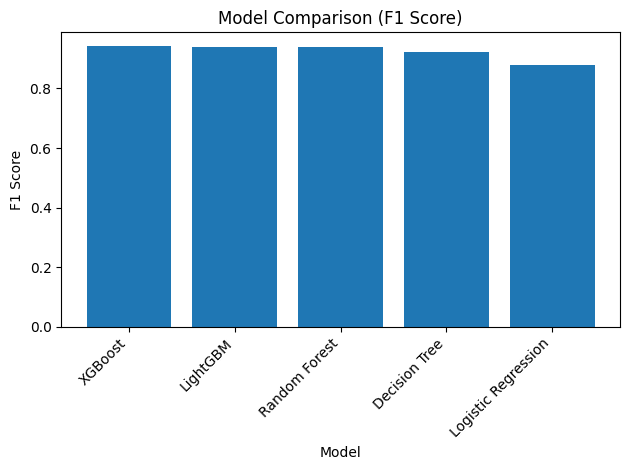


✅ Best Base Model: XGBoost | F1: 0.9412932853419387


In [15]:

candidate_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=6,
        subsample=0.9, colsample_bytree=0.9, eval_metric="logloss",
        random_state=42
    ),
    "LightGBM": LGBMClassifier(n_estimators=400, learning_rate=0.05, random_state=42)
}

results = []
best_name = None
best_pipe = None
best_f1 = -1

for name, model in candidate_models.items():
    pipe = build_model_pipeline(model)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    results.append((name, acc, f1))

    if f1 > best_f1:
        best_f1 = f1
        best_name = name
        best_pipe = pipe

    print("\n" + "="*60)
    print("MODEL:", name)
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", confusion_matrix(y_test, preds))

results_df = pd.DataFrame(results, columns=["Model","Accuracy","F1 Score"]).sort_values("F1 Score", ascending=False)
print("\n" + "="*60)
print("MODEL COMPARISON")
display(results_df)

plt.figure()
plt.bar(results_df["Model"], results_df["F1 Score"])
plt.title("Model Comparison (F1 Score)")
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print("\n✅ Best Base Model:", best_name, "| F1:", best_f1)


## 10) Bagging on the Best Model

In [16]:

best_base_estimator = best_pipe.named_steps["model"]

bagging_best = BaggingClassifier(
    estimator=best_base_estimator,
    n_estimators=30,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

bagging_pipe = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("select", SelectKBest(score_func=f_classif, k=25)),
    ("model", bagging_best)
])

bagging_pipe.fit(X_train, y_train)
bag_preds = bagging_pipe.predict(X_test)

print("\n" + "="*60)
print("BAGGING ON BEST MODEL:", best_name)
print("Accuracy:", accuracy_score(y_test, bag_preds))
print("F1 Score:", f1_score(y_test, bag_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, bag_preds))
print("\nClassification Report:\n", classification_report(y_test, bag_preds))



BAGGING ON BEST MODEL: XGBoost
Accuracy: 0.9367482092174618
F1 Score: 0.941747572815534
Confusion Matrix:
 [[3148  248]
 [ 220 3783]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      3396
           1       0.94      0.95      0.94      4003

    accuracy                           0.94      7399
   macro avg       0.94      0.94      0.94      7399
weighted avg       0.94      0.94      0.94      7399



## 11) Save Bagged Best Model

In [17]:

joblib.dump(bagging_pipe, "best_churn_model_bagged.pkl")
print("Saved: best_churn_model_bagged.pkl")


Saved: best_churn_model_bagged.pkl


## 12) Prediction Function

In [18]:

loaded_model = joblib.load("best_churn_model_bagged.pkl")

def predict_customer_churn(customer_data):
    customer_df = pd.DataFrame([customer_data])

    customer_df = customer_df.drop(columns=["sno"], errors="ignore")
    customer_df = customer_df.drop(columns=["security_no", "referral_id"], errors="ignore")

    customer_df["joining_date"] = pd.to_datetime(customer_df.get("joining_date"), errors="coerce")
    customer_df["last_visit_time"] = pd.to_datetime(customer_df.get("last_visit_time"), errors="coerce")

    today = pd.Timestamp(datetime.today().date())
    customer_df["days_since_joining"] = (today - customer_df["joining_date"]).dt.days
    customer_df["days_since_last_visit"] = (today - customer_df["last_visit_time"]).dt.days

    customer_df["days_since_joining"] = customer_df["days_since_joining"].fillna(df["days_since_joining"].median())
    customer_df["days_since_last_visit"] = customer_df["days_since_last_visit"].fillna(df["days_since_last_visit"].median())

    customer_df["sentiment_score"] = customer_df.get("feedback", pd.Series([None]*len(customer_df))).apply(analyze_sentiment)
    customer_df = customer_df.drop(columns=["joining_date", "last_visit_time", "feedback"], errors="ignore")

    for col in numeric_cols:
        if col in customer_df.columns:
            customer_df[col] = pd.to_numeric(customer_df[col], errors="coerce").fillna(X[col].median())
        else:
            customer_df[col] = X[col].median()

    for col in categorical_cols:
        if col in customer_df.columns:
            customer_df[col] = customer_df[col].fillna("Unknown").astype(str)
        else:
            customer_df[col] = "Unknown"

    pred = loaded_model.predict(customer_df)[0]
    return "Churn" if int(pred) == 1 else "Active"


## 13) ✅ User Input from Command Line (`input()`)
Run the cell below and enter values when prompted.

In [19]:

def ask_str(prompt, default="Unknown"):
    val = input(f"{prompt} (default: {default}): ").strip()
    return val if val else default

def ask_int(prompt, default=0):
    val = input(f"{prompt} (default: {default}): ").strip()
    if not val:
        return int(default)
    try:
        return int(val)
    except:
        return int(default)

def ask_float(prompt, default=0.0):
    val = input(f"{prompt} (default: {default}): ").strip()
    if not val:
        return float(default)
    try:
        return float(val)
    except:
        return float(default)

print("Enter customer details below. Press Enter to use defaults.\n")

customer = {
    "age": ask_int("Age", 25),
    "gender": ask_str("Gender (M/F)", "M"),
    "region_category": ask_str("Region Category", "Unknown"),
    "membership_category": ask_str("Membership Category", "Unknown"),
    "joining_date": ask_str("Joining Date (YYYY-MM-DD)", "2022-06-20"),
    "joined_through_referral": ask_str("Joined Through Referral (Yes/No)", "No"),
    "preferred_offer_types": ask_str("Preferred Offer Types", "Unknown"),
    "medium_of_operation": ask_str("Medium of Operation", "Unknown"),
    "internet_option": ask_str("Internet Option", "Unknown"),
    "last_visit_time": ask_str("Last Visit Time (YYYY-MM-DD)", "2025-12-15"),
    "days_since_last_login": ask_int("Days Since Last Login", 8),
    "points_in_wallet": ask_float("Points In Wallet", 120.0),
    "used_special_discount": ask_str("Used Special Discount (Yes/No)", "No"),
    "offer_application_preference": ask_str("Offer Application Preference (Yes/No)", "No"),
    "past_complaint": ask_str("Past Complaint (Yes/No)", "No"),
    "complaint_status": ask_str("Complaint Status", "Unknown"),
    "avg_time_spent": ask_float("Avg Time Spent", 300.0),
    "avg_transaction_value": ask_float("Avg Transaction Value", 500.0),
    "avg_frequency_login_days": ask_float("Avg Frequency Login Days", 10.0),
    "feedback": ask_str("Feedback (text)", "Great service.")
}

print("\n======================================")
print("Customer Input:")
for k, v in customer.items():
    print(f"{k}: {v}")

prediction = predict_customer_churn(customer)
print("\n✅ Prediction:", prediction)


Enter customer details below. Press Enter to use defaults.


Customer Input:
age: 21
gender: M
region_category: Unknown
membership_category: Unknown
joining_date: 2023-09-21
joined_through_referral: No
preferred_offer_types: Unknown
medium_of_operation: Unknown
internet_option: Unknown
last_visit_time: 2026-01-20
days_since_last_login: 5
points_in_wallet: 200.0
used_special_discount: No
offer_application_preference: No
past_complaint: No
complaint_status: Unknown
avg_time_spent: 150.0
avg_transaction_value: 1000.0
avg_frequency_login_days: 3.0
feedback: Good

✅ Prediction: Active
